<a href="https://colab.research.google.com/github/simseoyoung/NWDAF/blob/main/CH.8/8_1_GP_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Process Regression 



In [1]:
!pip install gpytorch
import math
import torch
import gpytorch #pytorch에서 제공하는 gpregression
from matplotlib import pyplot as plt
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 310 kB 5.0 MB/s 
  Created wheel for gpytorch: filename=gpytorch-1.6.0-py2.py3-none-any.whl size=509889 sha256=7d88c577290abbe3ef75164127f58443b4d39794c01f4f25f8f1d096e1816f04
  Stored in directory: /root/.cache/pip/wheels/66/b5/89/34c06ad393a6feb72b4cdde46d0f1c667f3e2632960f9df109
Successfully built gpytorch


### Data

-Sin함수를 Generator Function으로 하는 데이터셋을 생성한다  
-데이터셋도 Gaussian Distribution을 따르도록 생성한다

\begin{align}
y &= \sin(2\pi x) + \epsilon \\
  \epsilon &\sim \mathcal{N}(0, 0.04) 
\end{align}



In [2]:
torch.manual_seed(1111) # 랜덤시드 적용할 셀에 입력
train_x = torch.linspace(0,1, 100)  # 0~1사이 수를 100등분
print(train_x.size())
train_x                                                          

torch.Size([100])


tensor([0.0000, 0.0101, 0.0202, 0.0303, 0.0404, 0.0505, 0.0606, 0.0707, 0.0808,
        0.0909, 0.1010, 0.1111, 0.1212, 0.1313, 0.1414, 0.1515, 0.1616, 0.1717,
        0.1818, 0.1919, 0.2020, 0.2121, 0.2222, 0.2323, 0.2424, 0.2525, 0.2626,
        0.2727, 0.2828, 0.2929, 0.3030, 0.3131, 0.3232, 0.3333, 0.3434, 0.3535,
        0.3636, 0.3737, 0.3838, 0.3939, 0.4040, 0.4141, 0.4242, 0.4343, 0.4444,
        0.4545, 0.4646, 0.4747, 0.4848, 0.4949, 0.5051, 0.5152, 0.5253, 0.5354,
        0.5455, 0.5556, 0.5657, 0.5758, 0.5859, 0.5960, 0.6061, 0.6162, 0.6263,
        0.6364, 0.6465, 0.6566, 0.6667, 0.6768, 0.6869, 0.6970, 0.7071, 0.7172,
        0.7273, 0.7374, 0.7475, 0.7576, 0.7677, 0.7778, 0.7879, 0.7980, 0.8081,
        0.8182, 0.8283, 0.8384, 0.8485, 0.8586, 0.8687, 0.8788, 0.8889, 0.8990,
        0.9091, 0.9192, 0.9293, 0.9394, 0.9495, 0.9596, 0.9697, 0.9798, 0.9899,
        1.0000])

In [3]:
train_y = torch.sin(train_x*(2*math.pi)) + torch.randn(train_x.size())*math.sqrt(0.04) # 가우시안 노이즈 추가
train_y.shape

torch.Size([100])

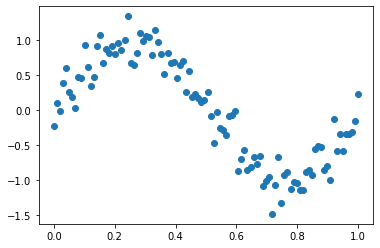

In [4]:
plt.scatter(train_x, train_y)
plt.show()  

## Model

### GP 관련 함수들

1.  **GP Model** (`gpytorch.models.ExactGP`)
1.  **Likelihood** (`gpytorch.likelihoods.GaussianLikelihood`)
1.  **Mean** - `gpytorch.means.ConstantMean()` 
1.  **Kernel** - `gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())` 
1.  **MultivariateNormal** (`gpytorch.distributions.MultivariateNormal`)
  

In [7]:

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean() # mean값 구하는 module
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        # Gaussian kernel가져와서 사용

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        distribution = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return distribution
    

In [6]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood) # GP 모델 선언
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [8]:
# GP의 loss 역할(최적화 방향성의 지표) - Marginal Log Likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

## Training


In [9]:
epoch = 20

model.train()
likelihood.train()

for i in range(epoch):
    optimizer.zero_grad()

    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, epoch, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()))
    

Iter 1/20 - Loss: 0.936   lengthscale: 0.644   noise: 0.644
Iter 2/20 - Loss: 0.904   lengthscale: 0.598   noise: 0.598
Iter 3/20 - Loss: 0.870   lengthscale: 0.555   noise: 0.554
Iter 4/20 - Loss: 0.833   lengthscale: 0.514   noise: 0.513
Iter 5/20 - Loss: 0.790   lengthscale: 0.475   noise: 0.474
Iter 6/20 - Loss: 0.743   lengthscale: 0.439   noise: 0.437
Iter 7/20 - Loss: 0.693   lengthscale: 0.404   noise: 0.402
Iter 8/20 - Loss: 0.642   lengthscale: 0.372   noise: 0.369
Iter 9/20 - Loss: 0.593   lengthscale: 0.342   noise: 0.339
Iter 10/20 - Loss: 0.548   lengthscale: 0.315   noise: 0.310
Iter 11/20 - Loss: 0.508   lengthscale: 0.292   noise: 0.284
Iter 12/20 - Loss: 0.470   lengthscale: 0.272   noise: 0.259
Iter 13/20 - Loss: 0.435   lengthscale: 0.256   noise: 0.237
Iter 14/20 - Loss: 0.401   lengthscale: 0.243   noise: 0.216
Iter 15/20 - Loss: 0.368   lengthscale: 0.233   noise: 0.196
Iter 16/20 - Loss: 0.335   lengthscale: 0.225   noise: 0.179
Iter 17/20 - Loss: 0.303   length

/usr/local/lib/python3.7/dist-packages/gpytorch/lazy/triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


## Prediction

In [15]:
model.eval()
likelihood.eval()

# TEST Mode 
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 3, 51) 
    #외삽 확인시 Train 범위 이상의 값을 입력
    #0-1 사이의 값으로 지정했으므로 확인하고 싶으면 1 이상의 값을 넣어주면 됨
    observed_pred = likelihood(model(test_x))    

## Result
-Confidence boundary 확인

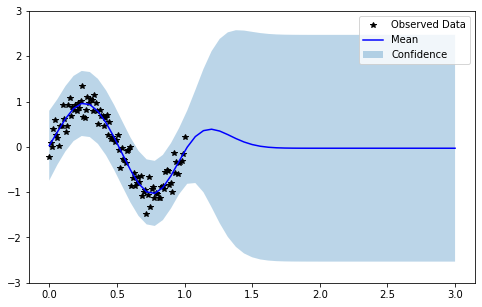

In [16]:
f, ax = plt.subplots(1, 1, figsize=(8, 5))
lower, upper = observed_pred.confidence_region()
ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')

# Confidence bound (boundary를 색칠함)
ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.3)
ax.set_ylim([-3, 3])# y값의 범위를 [-3, 3]

ax.legend(['Observed Data', 'Mean', 'Confidence'])
# GP의 장점으로 confidence boundary를 확인하면 알 수 있듯이 train data가 없는 범위에서 어느정도의 confidence를 갖는지 확인 가능함
# 아래 그래프 상으로 observed data가 있는 부분의 뒷부분 


[Reference](https://github.com/cornellius-gp/gpytorch/tree/master/examples)